##### [Draft Express Combine Measurements](http://www.draftexpress.com/nba-pre-draft-measurements/2017/NBA+Draft+Combine/all/all/1/height/desc)

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

In [2]:
#download HTML and create Beautiful Soup object
#change year in url to get results for different year
url = "http://www.draftexpress.com/nba-pre-draft-measurements/2016/NBA+Draft+Combine/all/all/1/height/desc"

response = requests.get(url)
html = response.content

soup = bs(html, 'lxml')

In [3]:
#retrieve data table from site
table = soup.find('table', attrs={'class': 'sorttable'})

#print(table.prettify())

In [4]:
#create list of column headers
df_headers = []
for item in table.findAll('th'):
    #only include headers that don't contain sub categories
    if item.has_attr("rowspan") and item.get("rowspan") == "2":
        df_headers.append(item.string.strip())

#I had to hard code the columns that contain sub categories i.e. height -> no shoes, shoes; vertical -> max, max reach, no, step, no step reach; hand -> length, width

#set desired start indices for sub categories in list of column headers
height_IDX = 3   
vertical_IDX = 7
hand_IDX = 13

for i in range(len(table.findAll('tr')[1].findAll('th'))):
    item = table.findAll('tr')[1].findAll('th')[i].string.strip()
    
    if i in range(0,2):
        df_headers.insert(height_IDX, item)
        height_IDX += 1
    elif i in range(2,6):
        df_headers.insert(vertical_IDX, item)
        vertical_IDX += 1
    else:
        df_headers.insert(hand_IDX, item)
        hand_IDX += 1
        
print(df_headers)

['Player', 'Year', 'Draft pick', 'No Shoes', 'With Shoes', 'Wingspan', 'Standing reach', 'Max', 'Max Reach', 'No Step', 'No Step Reach', 'Weight', 'Body Fat', 'Length', 'Width', 'Bench', 'Agility', 'Sprint']


In [5]:
#create dictionary from headers list: one for containing data; the other for containing index reference
df_dict = {}
df_idx_ref = {}
idx = 0
for name in df_headers:
    df_dict[name] = []
    df_idx_ref[idx] = name
    idx += 1
    
print("df_dict: {}\n".format(df_dict))
print("df_idx_ref: {}".format(df_idx_ref))

df_dict: {'Player': [], 'Year': [], 'Draft pick': [], 'No Shoes': [], 'With Shoes': [], 'Wingspan': [], 'Standing reach': [], 'Max': [], 'Max Reach': [], 'No Step': [], 'No Step Reach': [], 'Weight': [], 'Body Fat': [], 'Length': [], 'Width': [], 'Bench': [], 'Agility': [], 'Sprint': []}

df_idx_ref: {0: 'Player', 1: 'Year', 2: 'Draft pick', 3: 'No Shoes', 4: 'With Shoes', 5: 'Wingspan', 6: 'Standing reach', 7: 'Max', 8: 'Max Reach', 9: 'No Step', 10: 'No Step Reach', 11: 'Weight', 12: 'Body Fat', 13: 'Length', 14: 'Width', 15: 'Bench', 16: 'Agility', 17: 'Sprint'}


In [6]:
#populate df_dict with corresponding data from each row
rows = table.findAll('tr')[2:]

for row in rows:
    data = row.findAll('td')
    idx = 0
    for d in data:
        if d.has_attr('data-order'):
            if d.get('data-order').strip() in ['-1.0', '-1.00', '-']:
                df_dict[df_idx_ref[idx]].append(None)
            else:
                df_dict[df_idx_ref[idx]].append(round(float(d.get('data-order').strip()), 2))
                            
        else:
            #many columns don't contain data-order attribute
            #need to convert data type for columns: max, max reach, no step, no step reach, body fat, bench, agility, sprint
            if idx in [7, 8, 9, 10, 12, 15, 16, 17] and d.text.strip() != '-':
                df_dict[df_idx_ref[idx]].append(round(float(d.text.strip()),2))
            else:
                if d.text.strip() == '-':
                    df_dict[df_idx_ref[idx]].append(None)
                else:
                    df_dict[df_idx_ref[idx]].append(d.text.strip())
        idx += 1
        
#print out contents of df_dict
for key in df_dict:
    print('{}: {}\n'.format(key, df_dict[key]))

Player: ['Zhou Qi', 'Jakob Poeltl', 'Thon Maker', 'Skal Labissiere', 'Damian Jones', 'Stephen Zimmerman', 'Henry Ellenson', 'Deyonta Davis', 'Brice Johnson', 'Marcus Lee', 'Chinanu Onuaku', 'Diamond Stone', 'Marquese Chriss', 'Kyle Wiltjer', 'Jarrod Uthoff', 'Pascal Siakam', 'Jake Layman', 'Joel Bolomboy', 'Cheick Diallo', 'Caleb Swanigan', 'Ben Bentil', 'Perry Ellis', 'Justin Jackson', 'Dedric Lawson', 'Robert Carter', 'Isaiah Miles', 'Georges Niang', 'Dorian Finney-Smith', 'Taurean Prince', 'Jaron Blossomgame', 'Daniel Hamilton', 'Nigel Hayes', 'Caris LeVert', 'Troy Williams', 'Michael Gbinije', 'Jaylen Brown', 'Patrick McCaw', 'Elgin Cook', 'Sheldon McClellan', 'Malachi Richardson', 'DeAndre Bembry', 'Wayne Selden', 'Josh Hart', 'Denzel Valentine', 'Malcolm Brogdon', 'Buddy Hield', 'Malik Beasley', 'Ron Baker', 'Isaiah Cousins', 'Isaiah Whitehead', 'Kris Dunn', 'Wade Baldwin', 'Malik Newman', 'A.J. English', 'Gary Payton II', 'Cat Barber', 'Melo Trimble', 'Marcus Paige', 'Demetrius 

In [7]:
#check to see that each column contains same number of entries
for key in df_dict:
    print("{}: {}".format(key,len(df_dict[key])))

Player: 61
Year: 61
Draft pick: 61
No Shoes: 61
With Shoes: 61
Wingspan: 61
Standing reach: 61
Max: 61
Max Reach: 61
No Step: 61
No Step Reach: 61
Weight: 61
Body Fat: 61
Length: 61
Width: 61
Bench: 61
Agility: 61
Sprint: 61


In [8]:
#convert dictionary to dataframe
df = pd.DataFrame(df_dict, columns=df_dict.keys())

#if draft hasn't occurred, sort dataframe in alphabetical order based on player name; change by argument in sort_values from 'Player' to 'Draft Pick'
#reset index for dataframe
df = df.sort_values(by=['Draft pick', 'Player']).reset_index(drop=True)

#rename columns that are subcategories of Height, Vertical, or Hand on Draft Express
df = df.rename(columns= {
    'No Shoes': 'Height (No Shoes)',
    'With Shoes': 'Height (With Shoes)',
    'Max': 'Vertical (Max)',
    'Max Reach': 'Vertical (Max Reach)',
    'No Step': 'Vertical (No Step)',
    'No Step Reach': 'Vertical (No Step Reach)',
    'Length': 'Hand (Length)',
    'Width': 'Hand (Width)'
})

df

,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,Thon Maker,2016,10,83.75,84.75,87.00,110.5,36.5,147.0,32.0,142.5,216.0,6.1,8.75,9.50,None,11.15,3.33
1,Taurean Prince,2016,12,78.50,79.75,83.50,102.0,36.0,138.0,34.0,136.0,220.0,6.5,9.00,8.50,None,10.96,3.24
2,Denzel Valentine,2016,14,76.00,77.75,82.75,102.0,32.0,134.0,27.0,129.0,210.0,9.2,8.50,9.75,None,10.51,3.46
3,Wade Baldwin,2016,17,74.50,76.00,83.25,100.0,38.0,138.0,32.5,132.5,202.0,5.2,9.00,9.75,None,10.45,3.19
4,Henry Ellenson,2016,18,82.00,83.50,86.25,108.0,NaN,NaN,NaN,NaN,242.0,11.2,8.50,9.75,None,NaN,NaN
5,Malik Beasley,2016,19,75.50,76.50,79.00,100.5,NaN,NaN,NaN,NaN,190.0,6.9,8.50,9.00,None,NaN,NaN
6,Caris LeVert,2016,20,77.75,79.00,82.00,101.0,NaN,NaN,NaN,NaN,191.0,7.6,8.50,9.25,None,NaN,NaN
7,DeAndre Bembry,2016,21,76.25,77.75,81.25,101.0,38.0,139.0,32.0,133.0,207.0,7.0,8.00,9.25,None,10.90,3.17
8,Malachi Richardson,2016,22,76.75,78.25,84.00,101.5,38.0,139.5,33.0,134.5,200.0,7.0,8.75,10.00,None,10.56,3.33
9,Brice Johnson,2016,25,81.00,82.50,84.50,106.5,38.0,144.5,33.5,140.0,209.0,7.5,9.00,8.25,None,11.88,3.20


In [9]:
#get summary statistics of dataframe
round(df.describe(), 2)

,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Agility,Sprint
count,61.00,61.00,61.00,61.00,49.00,49.00,49.00,49.00,60.00,60.00,61.00,61.00,49.00,48.00
mean,77.84,79.11,82.89,102.49,35.70,138.08,30.35,132.72,212.60,7.28,8.49,9.04,11.28,3.31
std,3.42,3.40,3.71,4.98,3.77,4.29,3.54,5.19,22.44,2.53,1.31,1.46,0.57,0.13
min,68.25,69.50,74.00,88.50,28.00,126.50,22.50,119.00,149.00,4.00,-1.00,-1.00,10.26,3.12
25%,75.75,77.00,81.00,100.00,33.50,135.50,27.50,129.00,197.75,5.38,8.25,8.75,10.81,3.20
50%,78.25,79.25,82.50,102.00,35.50,138.00,30.50,133.00,213.50,6.50,8.75,9.25,11.25,3.26
75%,80.25,81.50,86.50,106.50,38.00,141.00,32.50,136.00,227.50,8.75,9.00,9.50,11.65,3.40
max,85.25,86.25,91.75,112.50,44.00,147.00,37.50,144.00,254.00,15.30,9.50,10.50,12.80,3.65


In [10]:
#create csv file from dataframe
df.to_csv('2016_nba_draft_combine.csv')

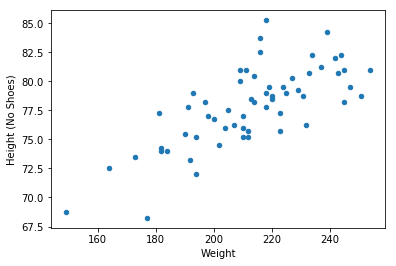

In [11]:
#Can now perform visualization and analysis on dataframe using matplotlib and pandas
import matplotlib.pyplot as plt
%matplotlib inline

#simple scatter plot
df.plot.scatter('Weight', 'Height (No Shoes)')